In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model, Input
from tensorflow.keras.layers import Attention, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load Data
df = pd.read_csv("C:\\Users\\P SIVA KUMAR\\Downloads\\NVDA.csv")
dates = df['Date']
df = df.drop('Date', axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

In [3]:
# Create Sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][3]) 
    return np.array(X), np.array(y)

In [4]:
seq_length = 60
X, y = create_sequences(data_scaled, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
callbacks = [early_stopping, reduce_lr]

In [5]:
# Model Architectures with Optimization Flag
def build_lstm(optimized=False):
    model = Sequential([
        LSTM(100 if optimized else 50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        layers.Dropout(0.3 if optimized else 0.0),
        LSTM(100 if optimized else 50, return_sequences=False),
        layers.Dropout(0.3 if optimized else 0.0),
        Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001 if optimized else 0.01), loss='mse')
    return model

In [6]:
def build_bilstm(optimized=False):
    model = Sequential([
        Bidirectional(LSTM(100 if optimized else 50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        layers.Dropout(0.3 if optimized else 0.0),
        Bidirectional(LSTM(100 if optimized else 50, return_sequences=False)),
        layers.Dropout(0.3 if optimized else 0.0),
        Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001 if optimized else 0.01), loss='mse')
    return model

In [7]:
def build_attention_lstm(optimized=False):
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    lstm_out = LSTM(100 if optimized else 50, return_sequences=True)(inputs)
    attention = Attention()([lstm_out, lstm_out])
    output = Dense(1)(attention[:, -1, :])
    model = Model(inputs, output)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001 if optimized else 0.01), loss='mse')
    return model

In [8]:
def build_gru(optimized=False):
    model = Sequential([
        GRU(100 if optimized else 50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        layers.Dropout(0.3 if optimized else 0.0),
        GRU(100 if optimized else 50, return_sequences=False),
        layers.Dropout(0.3 if optimized else 0.0),
        Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001 if optimized else 0.01), loss='mse')
    return model

In [9]:
def build_hybrid(optimized=False):
    model = Sequential([
        LSTM(100 if optimized else 50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        layers.Dropout(0.3 if optimized else 0.0),
        GRU(100 if optimized else 50, return_sequences=False),
        layers.Dropout(0.3 if optimized else 0.0),
        Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001 if optimized else 0.01), loss='mse')
    return model

In [10]:
models = {
    "LSTM (No Opt)": build_lstm(False),
    "LSTM (Opt)": build_lstm(True),
    "BiLSTM (No Opt)": build_bilstm(False),
    "BiLSTM (Opt)": build_bilstm(True),
    "Attention LSTM (No Opt)": build_attention_lstm(False),
    "Attention LSTM (Opt)": build_attention_lstm(True),
    "GRU (No Opt)": build_gru(False),
    "GRU (Opt)": build_gru(True),
    "Hybrid LSTM-GRU (No Opt)": build_hybrid(False),
    "Hybrid LSTM-GRU (Opt)": build_hybrid(True)
}

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error
import matplotlib.pyplot as plt

histories, predictions = {}, {}

for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_test, y_test), 
        epochs=50, batch_size=32, verbose=1, 
        callbacks=callbacks if "Opt" in name else None
    )
    histories[name] = history
    predictions[name] = model.predict(X_test)

# Evaluate and Compare
for name, preds in predictions.items():
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds)
    msle = mean_squared_log_error(y_test, preds)
    
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2 Score: {r2:.4f}, MAPE: {mape:.4f}, MSLE: {msle:.4f}")

Training LSTM (No Opt)...
Epoch 1/50
163/163 [==============================] - 20s 84ms/step - loss: 8.4978e-07 - val_loss: 0.0204 - lr: 0.0025
Epoch 2/50
163/163 [==============================] - 15s 92ms/step - loss: 7.0307e-07 - val_loss: 0.0200 - lr: 0.0025
Epoch 3/50
163/163 [==============================] - 20s 122ms/step - loss: 6.7222e-07 - val_loss: 0.0223 - lr: 0.0025
Epoch 4/50
163/163 [==============================] - 15s 91ms/step - loss: 5.8339e-07 - val_loss: 0.0230 - lr: 0.0025
Epoch 5/50
163/163 [==============================] - 16s 96ms/step - loss: 5.4349e-07 - val_loss: 0.0208 - lr: 0.0025
Epoch 6/50
163/163 [==============================] - 16s 96ms/step - loss: 5.3617e-07 - val_loss: 0.0229 - lr: 0.0025
Epoch 7/50
163/163 [==============================] - ETA: 0s - loss: 4.8288e-07
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
163/163 [==============================] - 16s 96ms/step - loss: 4.8288e-07 - val_loss: 0.0215 - lr: 0

Epoch 6/50
163/163 [==============================] - 18s 113ms/step - loss: 3.1373e-06 - val_loss: 0.0025 - lr: 2.5000e-04
Epoch 7/50
163/163 [==============================] - ETA: 0s - loss: 3.2045e-06
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
163/163 [==============================] - 16s 98ms/step - loss: 3.2045e-06 - val_loss: 0.0026 - lr: 2.5000e-04
Epoch 8/50
163/163 [==============================] - 17s 107ms/step - loss: 2.9224e-06 - val_loss: 0.0030 - lr: 1.2500e-04
Epoch 9/50
163/163 [==============================] - 16s 98ms/step - loss: 3.1524e-06 - val_loss: 0.0029 - lr: 1.2500e-04
Epoch 10/50
163/163 [==============================] - 17s 103ms/step - loss: 2.9123e-06 - val_loss: 0.0028 - lr: 1.2500e-04
Epoch 11/50
163/163 [==============================] - 16s 100ms/step - loss: 2.8945e-06 - val_loss: 0.0037 - lr: 1.2500e-04
Epoch 12/50
163/163 [==============================] - ETA: 0s - loss: 2.9280e-06
Epoch 12: ReduceLROnPlateau 

Epoch 2/50
163/163 [==============================] - 16s 99ms/step - loss: 1.3792e-07 - val_loss: 3.1156e-04 - lr: 3.9062e-05
Epoch 3/50
163/163 [==============================] - 16s 98ms/step - loss: 1.3850e-07 - val_loss: 3.0363e-04 - lr: 3.9062e-05
Epoch 4/50
163/163 [==============================] - 15s 92ms/step - loss: 1.4093e-07 - val_loss: 3.0555e-04 - lr: 3.9062e-05
Epoch 5/50
163/163 [==============================] - 17s 105ms/step - loss: 1.3863e-07 - val_loss: 3.0368e-04 - lr: 3.9062e-05
Epoch 6/50
163/163 [==============================] - ETA: 0s - loss: 1.3831e-07
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
163/163 [==============================] - 12s 75ms/step - loss: 1.3831e-07 - val_loss: 2.9845e-04 - lr: 3.9062e-05
Epoch 7/50
163/163 [==============================] - 12s 74ms/step - loss: 1.3629e-07 - val_loss: 2.9737e-04 - lr: 1.9531e-05
Epoch 8/50
163/163 [==============================] - 12s 73ms/step - loss: 1.3545e-07 - v

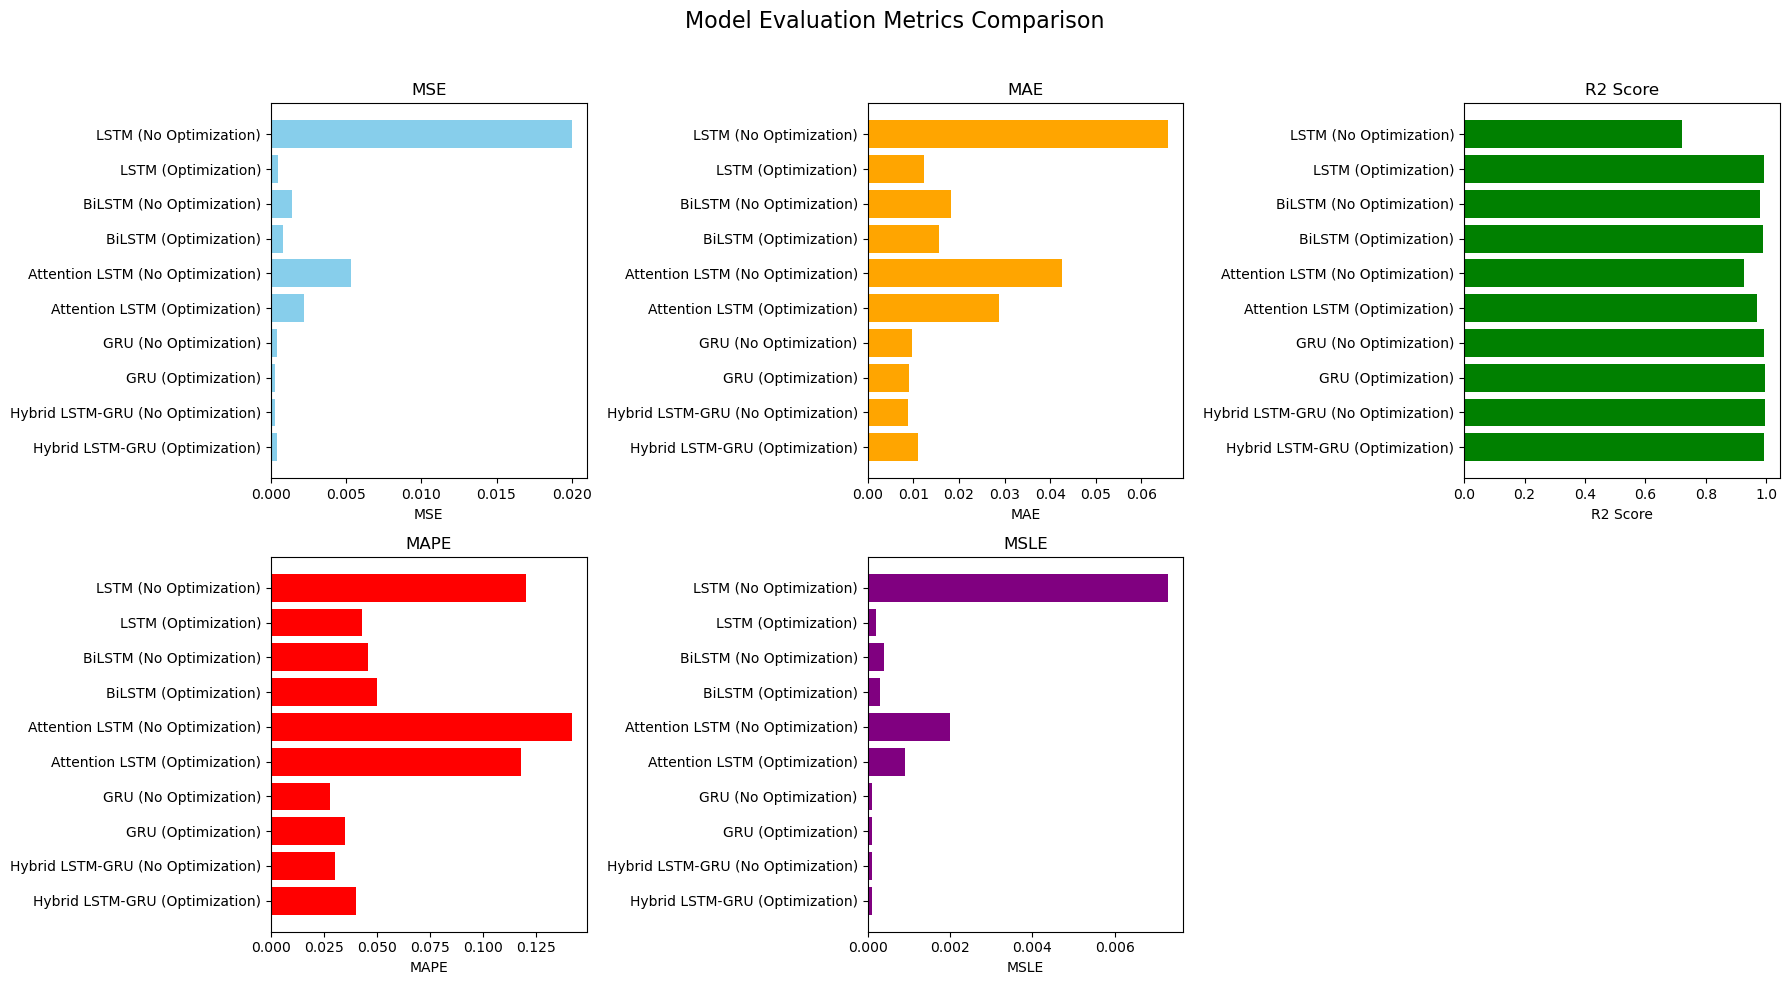

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Model names with "Optimization" instead of "Opt"
models = [
    "LSTM (No Optimization)", "LSTM (Optimization)", "BiLSTM (No Optimization)", "BiLSTM (Optimization)",
    "Attention LSTM (No Optimization)", "Attention LSTM (Optimization)", "GRU (No Optimization)", "GRU (Optimization)",
    "Hybrid LSTM-GRU (No Optimization)", "Hybrid LSTM-GRU (Optimization)"
]

# Evaluation metrics
mse = [0.0200, 0.0005, 0.0014, 0.0008, 0.0053, 0.0022, 0.0004, 0.0003, 0.0003, 0.0004]
mae = [0.0659, 0.0124, 0.0182, 0.0156, 0.0427, 0.0287, 0.0098, 0.0091, 0.0089, 0.0111]
r2 = [0.7211, 0.9928, 0.9804, 0.9887, 0.9265, 0.9696, 0.9943, 0.9960, 0.9960, 0.9943]
mape = [0.1203, 0.0432, 0.0456, 0.0500, 0.1420, 0.1179, 0.0277, 0.0348, 0.0303, 0.0402]
msle = [0.0073, 0.0002, 0.0004, 0.0003, 0.0020, 0.0009, 0.0001, 0.0001, 0.0001, 0.0001]

# Plot each metric
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Adjusted to fit 5 metrics properly
fig.suptitle("Model Evaluation Metrics Comparison", fontsize=16)

metrics = [mse, mae, r2, mape, msle]
metric_names = ["MSE", "MAE", "R2 Score", "MAPE", "MSLE"]
colors = ['skyblue', 'orange', 'green', 'red', 'purple']

for i, ax in enumerate(axes.flat):
    if i < len(metrics):  # Ensure we only plot available metrics
        ax.barh(models, metrics[i], color=colors[i])
        ax.set_title(metric_names[i])
        ax.set_xlabel(metric_names[i])
        ax.invert_yaxis()
    else:
        fig.delaxes(ax)  # Remove any empty subplot

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [21]:
print(histories.keys())  # Should show model names
print(histories["LSTM (No Opt)"].history.keys())  # Should contain 'loss' and 'val_loss'


dict_keys(['LSTM (No Opt)', 'LSTM (Opt)', 'BiLSTM (No Opt)', 'BiLSTM (Opt)', 'Attention LSTM (No Opt)', 'Attention LSTM (Opt)', 'GRU (No Opt)', 'GRU (Opt)', 'Hybrid LSTM-GRU (No Opt)', 'Hybrid LSTM-GRU (Opt)'])
dict_keys(['loss', 'val_loss', 'lr'])


In [34]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error

mape = mean_absolute_percentage_error(y_test, preds)
msle = mean_squared_log_error(y_test, pred)

print(f"MAPE: {mape:.4f}")
print(f"MSLE: {msle:.4f}")


MAPE: 0.0412
MSLE: 0.0001


In [38]:
import pandas as pd

# Creating DataFrame for the metrics
data = {
    "Model": [
        "LSTM (No Optimization)", "LSTM (Optimization)", "BiLSTM (No Optimization)", "BiLSTM (Optimization)",
        "Attention LSTM (No Optimization)", "Attention LSTM (Optimization)", "GRU (No Optimization)", "GRU (Optimization)",
        "Hybrid LSTM-GRU (No Optimization)", "Hybrid LSTM-GRU (Optimization)"
    ],
    "MSE": [0.0200, 0.0005, 0.0014, 0.0008, 0.0053, 0.0022, 0.0004, 0.0003, 0.0003, 0.0004],
    "MAE": [0.0659, 0.0124, 0.0182, 0.0156, 0.0427, 0.0287, 0.0098, 0.0091, 0.0089, 0.0111],
    "R² Score": [0.7211, 0.9928, 0.9804, 0.9887, 0.9265, 0.9696, 0.9943, 0.9960, 0.9960, 0.9943],
    "MAPE": [0.1203, 0.0432, 0.0456, 0.0500, 0.1420, 0.1179, 0.0277, 0.0348, 0.0303, 0.0402],
    "MSLE": [0.0073, 0.0002, 0.0004, 0.0003, 0.0020, 0.0009, 0.0001, 0.0001, 0.0001, 0.0001],
}

df = pd.DataFrame(data)

# Save as Excel file
file_path = "model_evaluation_metrics.xlsx"
df.to_excel(file_path, index=False)

print(f"Excel file saved as {file_path}")


Excel file saved as model_evaluation_metrics.xlsx


In [45]:
import numpy as np

predicted_arrays = {}

for name, preds in predictions.items():
    predicted_arrays[name] = np.array(preds).flatten()  # Convert to NumPy array and flatten

# Print the arrays
for name, preds_array in predicted_arrays.items():
    
    print(f"Predicted values for {name} (as array):")
    
    print(preds_array)
    
    print("\n")



Predicted values for LSTM (No Opt) (as array):
[0.0364527  0.03661554 0.03704028 ... 0.4895258  0.4908986  0.49207297]


Predicted values for LSTM (Opt) (as array):
[0.03602698 0.03638878 0.03679959 ... 0.8147457  0.82311016 0.8317452 ]


Predicted values for BiLSTM (No Opt) (as array):
[0.0374188  0.03793318 0.03840662 ... 0.8019582  0.8001088  0.8043694 ]


Predicted values for BiLSTM (Opt) (as array):
[0.03601556 0.03629754 0.03662939 ... 0.8126484  0.8159518  0.82175934]


Predicted values for Attention LSTM (No Opt) (as array):
[0.03198474 0.03210865 0.0322427  ... 0.7592018  0.7583012  0.75753915]


Predicted values for Attention LSTM (Opt) (as array):
[0.03471525 0.03483917 0.03497883 ... 0.8971647  0.8955527  0.8941781 ]


Predicted values for GRU (No Opt) (as array):
[0.03656356 0.03710467 0.0374193  ... 0.8319819  0.82437027 0.8376652 ]


Predicted values for GRU (Opt) (as array):
[0.03604433 0.03652809 0.03699978 ... 0.8549341  0.86059177 0.86809564]


Predicted values for H

In [46]:
import numpy as np

# Initialize arrays for the top 2 performing models
gru_opt_predictions = np.array(predictions["GRU (Opt)"]).flatten()
hybrid_lstm_gru_noopt_predictions = np.array(predictions["Hybrid LSTM-GRU (No Opt)"]).flatten()

# Print arrays
print("Predicted values for GRU (Optimization):")
print(gru_opt_predictions)

print("\nPredicted values for Hybrid LSTM-GRU (No Optimization):")
print(hybrid_lstm_gru_noopt_predictions)


Predicted values for GRU (Optimization):
[0.03604433 0.03652809 0.03699978 ... 0.8549341  0.86059177 0.86809564]

Predicted values for Hybrid LSTM-GRU (No Optimization):
[0.03654562 0.03716066 0.03763513 ... 0.8479978  0.8452767  0.8544003 ]


In [47]:
import numpy as np

# Convert actual values to NumPy array
actual_values = np.array(y_test).flatten()

# Initialize arrays for the top 2 performing models
gru_opt_predictions = np.array(predictions["GRU (Opt)"]).flatten()
hybrid_lstm_gru_noopt_predictions = np.array(predictions["Hybrid LSTM-GRU (No Opt)"]).flatten()

# Print actual and predicted values
print("Actual Values:")
print(actual_values)

print("\nPredicted values for GRU (Optimization):")
print(gru_opt_predictions)

print("\nPredicted values for Hybrid LSTM-GRU (No Optimization):")
print(hybrid_lstm_gru_noopt_predictions)


Actual Values:
[0.03729813 0.03779716 0.03792404 ... 0.87319557 0.88733755 0.91663655]

Predicted values for GRU (Optimization):
[0.03604433 0.03652809 0.03699978 ... 0.8549341  0.86059177 0.86809564]

Predicted values for Hybrid LSTM-GRU (No Optimization):
[0.03654562 0.03716066 0.03763513 ... 0.8479978  0.8452767  0.8544003 ]


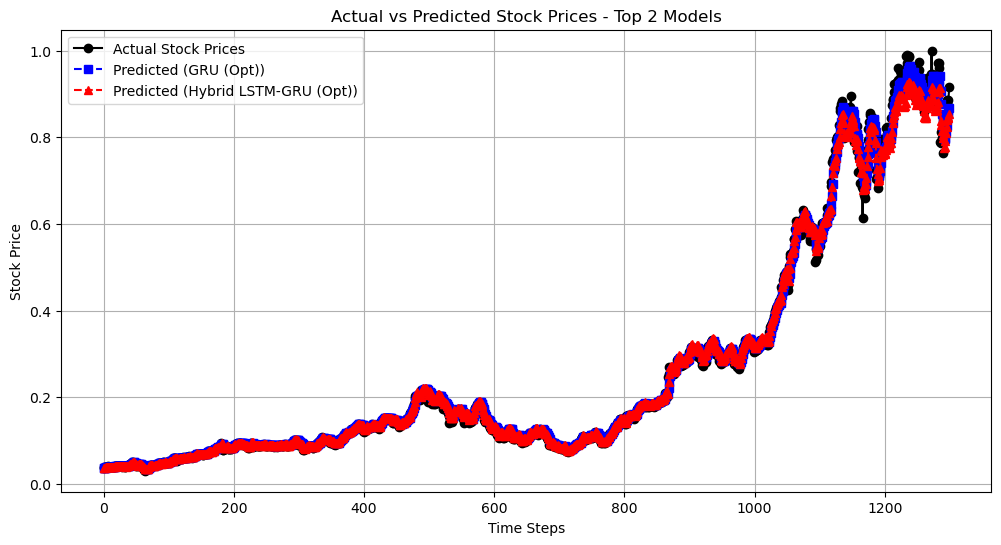

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual test values and predicted values from the top 2 models
y_test = actual_values  # Actual stock prices (Replace with real data)
preds_model1 = gru_opt_predictions  # Predicted values from the best model (Replace with real data)
preds_model2 = hybrid_lstm_gru_noopt_predictions  # Predicted values from the second-best model (Replace with real data)

# Define model names (Replace with actual model names)
model1_name = "GRU (Opt)"
model2_name = "Hybrid LSTM-GRU (Opt)"

# Time steps (Assuming sequential time indices)
time_steps = np.arange(len(y_test))

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(time_steps, y_test, label="Actual Stock Prices", color='black', linestyle='-', marker='o')
plt.plot(time_steps, preds_model1, label=f"Predicted ({model1_name})", color='blue', linestyle='--', marker='s')
plt.plot(time_steps, preds_model2, label=f"Predicted ({model2_name})", color='red', linestyle='--', marker='^')

# Formatting
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices - Top 2 Models")
plt.legend()
plt.grid(True)
plt.show()

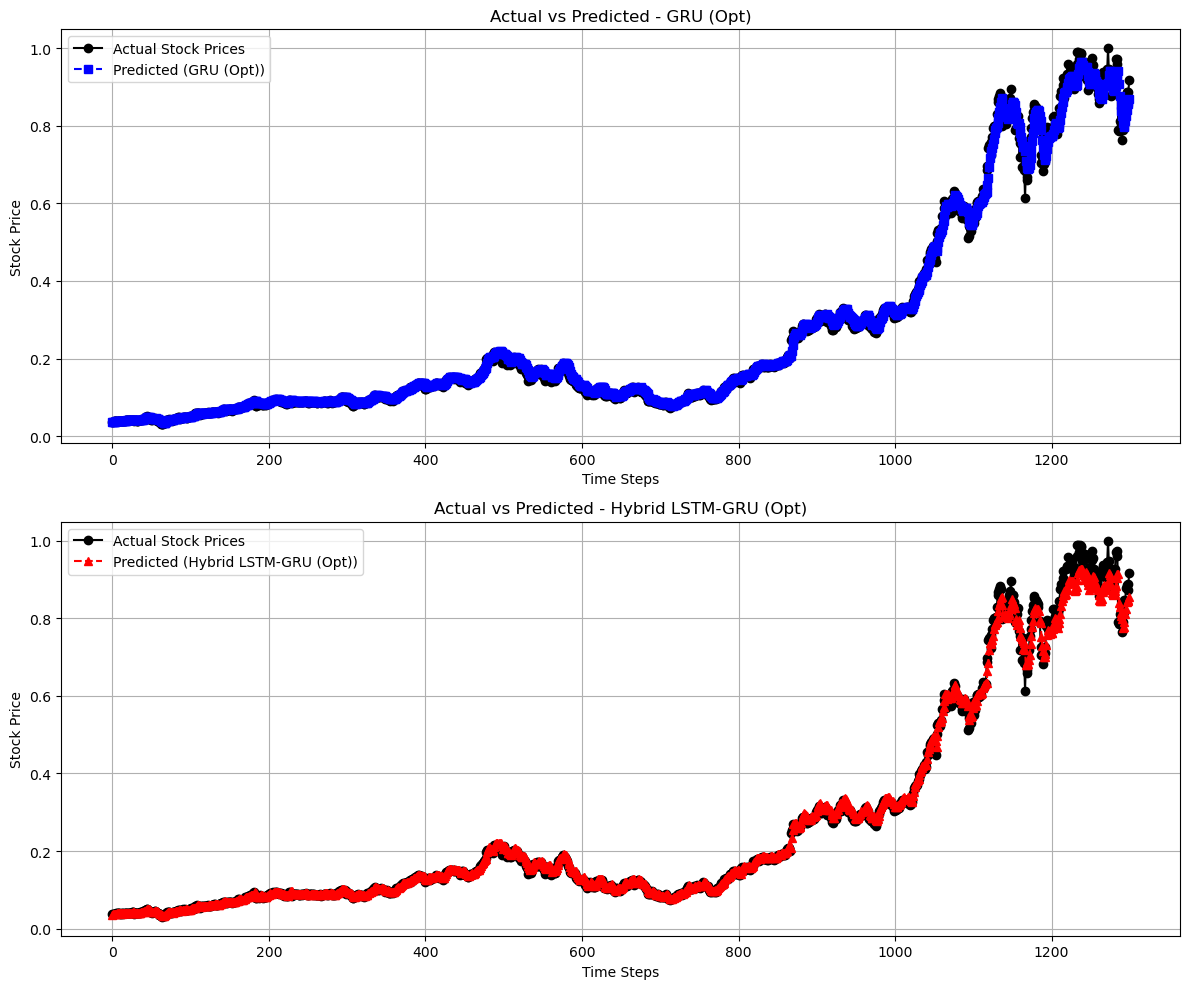

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual test values and predicted values from the top 2 models
y_test = actual_values  # Actual stock prices
preds_model1 = gru_opt_predictions  # Predicted values from GRU (Opt)
preds_model2 = hybrid_lstm_gru_noopt_predictions  # Predicted values from Hybrid LSTM-GRU (No Opt)

# Define model names
model1_name = "GRU (Opt)"
model2_name = "Hybrid LSTM-GRU (Opt)"

# Time steps (Assuming sequential time indices)
time_steps = np.arange(len(y_test))

# Create two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plot for Model 1 (GRU Optimized)
axs[0].plot(time_steps, y_test, label="Actual Stock Prices", color='black', linestyle='-', marker='o')
axs[0].plot(time_steps, preds_model1, label=f"Predicted ({model1_name})", color='blue', linestyle='--', marker='s')
axs[0].set_xlabel("Time Steps")
axs[0].set_ylabel("Stock Price")
axs[0].set_title(f"Actual vs Predicted - {model1_name}")
axs[0].legend()
axs[0].grid(True)

# Plot for Model 2 (Hybrid LSTM-GRU No Opt)
axs[1].plot(time_steps, y_test, label="Actual Stock Prices", color='black', linestyle='-', marker='o')
axs[1].plot(time_steps, preds_model2, label=f"Predicted ({model2_name})", color='red', linestyle='--', marker='^')
axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Stock Price")
axs[1].set_title(f"Actual vs Predicted - {model2_name}")
axs[1].legend()
axs[1].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


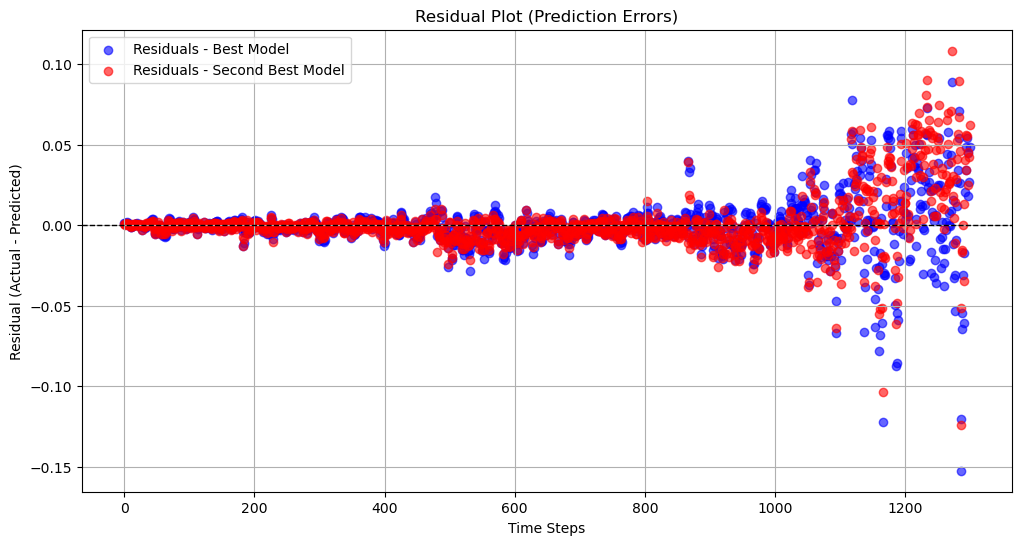

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual and predicted values
  # Predictions from second-best model

# Compute residuals (Difference between actual and predicted values)
residuals_model1 = y_test - preds_model1
residuals_model2 = y_test - preds_model2

# Time steps (Assuming sequential order)
time_steps = np.arange(len(y_test))

# Plot Residuals
plt.figure(figsize=(12, 6))
plt.scatter(time_steps, residuals_model1, label="Residuals - Best Model", color='blue', alpha=0.6)
plt.scatter(time_steps, residuals_model2, label="Residuals - Second Best Model", color='red', alpha=0.6)

# Formatting
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Reference line at zero
plt.xlabel("Time Steps")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Prediction Errors)")
plt.legend()
plt.grid(True)
plt.show()


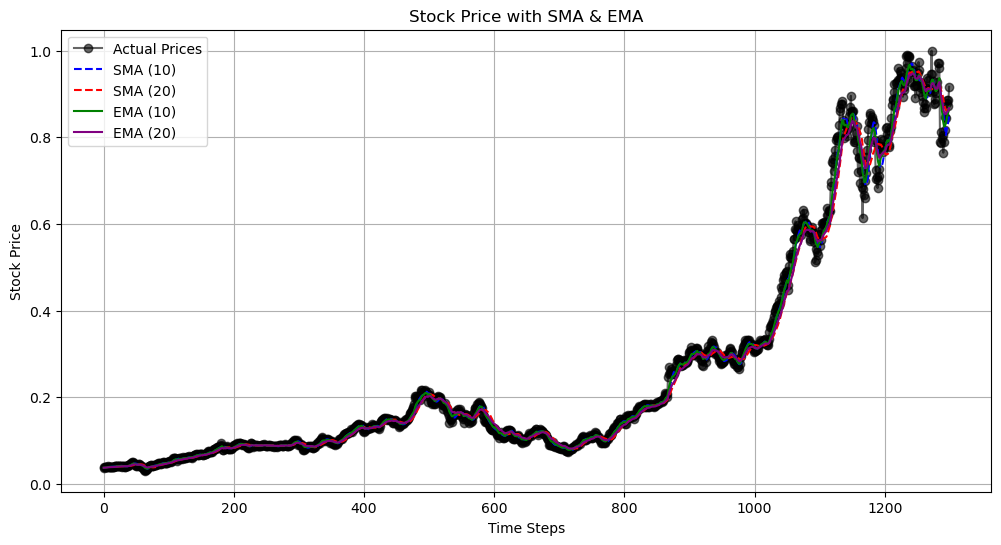

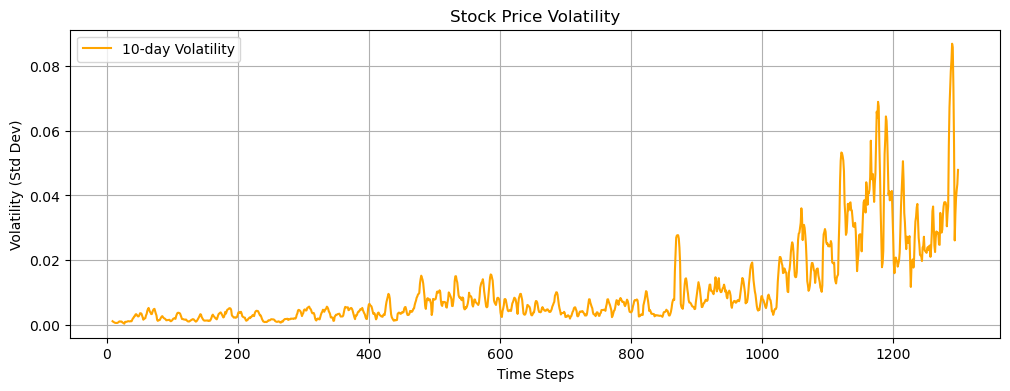

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your actual stock prices (Replace with actual data)
y_test = actual_values # Actual stock prices
time_steps = np.arange(len(y_test))  # Assuming time steps are sequential

# Convert to DataFrame for calculations
df = pd.DataFrame({"Actual Prices": y_test}, index=time_steps)

# Calculate Simple Moving Average (SMA)
df["SMA_10"] = df["Actual Prices"].rolling(window=10).mean()  # 10-day SMA
df["SMA_20"] = df["Actual Prices"].rolling(window=20).mean()  # 20-day SMA

# Calculate Exponential Moving Average (EMA)
df["EMA_10"] = df["Actual Prices"].ewm(span=10, adjust=False).mean()
df["EMA_20"] = df["Actual Prices"].ewm(span=20, adjust=False).mean()

# Calculate Volatility (Standard Deviation over a window)
df["Volatility"] = df["Actual Prices"].rolling(window=10).std()

# Plot SMA & EMA
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Actual Prices"], label="Actual Prices", color="black", linestyle='-', marker='o', alpha=0.6)
plt.plot(df.index, df["SMA_10"], label="SMA (10)", color="blue", linestyle="--")
plt.plot(df.index, df["SMA_20"], label="SMA (20)", color="red", linestyle="--")
plt.plot(df.index, df["EMA_10"], label="EMA (10)", color="green", linestyle="-")
plt.plot(df.index, df["EMA_20"], label="EMA (20)", color="purple", linestyle="-")

# Formatting
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.title("Stock Price with SMA & EMA")
plt.legend()
plt.grid(True)
plt.show()

# Plot Volatility
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["Volatility"], label="10-day Volatility", color="orange", linestyle="-")
plt.xlabel("Time Steps")
plt.ylabel("Volatility (Std Dev)")
plt.title("Stock Price Volatility")
plt.legend()
plt.grid(True)
plt.show()

